# Server Performance - Before and After

In early 2016, while ramping up usage of a 3rd party network appliance, our team at PayPal began to receive reports of clients experiencing failures. These failures were timeouts, and seemed too coincidental to not correspond to load. But load was still much lower than the advertised capacity of the device.

The latency and throughput numbers from the vendor were averages, we knew we had to dig deeper than their microbenchmarks. This notebook serves to make these issues appear very clear, and demonstrate that the only good benchmark is an idiosyncratic one.

Data points were generated by running a bank of processes putting load on the target server, and then running a single process sampling ten times per second. The timestamp and request-response latency are written to CSVs. For simplicity, this basic example only shows one before and one after. In reality the test harness was producing several controlled levels of load on the side, and the sampling process remained constant. This Jupyter notebook processes those CSVs, using pandas and matplotlib, packaged by Anaconda.

With the driver and analysis code in hand, the vendor was able to run the benchmark themselves, and issue a patch within weeks. The update completely fixed the issue we were seeing, and it is telling that the average didn't even change much.

Always remember, [the average is the premiere antipattern of scalability statistics](https://www.paypal-engineering.com/2016/04/11/statistics-for-software/).

In [1]:
%matplotlib inline

import pandas

In [2]:
import glob

FILES = glob.glob('/x/home/kurose/*_srv.csv')
"""
Expected format is comma-separated, floating-point pairs ("timestamp, latency").

1459452334.73, 0.00141596794128
1459452334.83, 0.00196099281311
1459452334.93, 0.00141191482544
...

"""

In [39]:
import os.path
import datetime


def file2pts(path):
    f = open(path)
    points = []
    for i, line in enumerate(f):
        clock, latency = line.split(',')
        points.append((datetime.datetime.fromtimestamp(float(clock)), float(latency)))
    return points


def pts2series(pts):
    return (pandas.Series([e[1] for e in pts], index=[e[0] for e in pts]) * 1000)


def all_files2series(files):
    file_series = {}
    df = pandas.DataFrame()
    all_pts = []
    for path in sorted(files, reverse=True):
        try:
            pts = file2pts(path)
            all_pts.extend(pts)
            name = os.path.split(path)[1]
            file_series[name] = pts2series(pts)
            df[name] = pandas.Series([e[1] for e in pts]) * 1000
        except Exception:
            import traceback
            traceback.print_exc()
    return file_series, df, all_pts

        
FILE_SERIES, DATAFRAME, ALL_PTS = all_files2series(FILES)
NEW = FILE_SERIES['new_srv.csv']
OLD = FILE_SERIES['old_srv.csv']

#Error rate (percentage response times > 20ms)

For this use case, the service SLA was 20ms so any responses longer than that count as an error.

In [28]:
print "old {0:0.02f}%".format(sum(OLD > 20) * 1.0 / len(OLD) * 100)
print "new {0:0.02f}%".format(sum(NEW > 20) * 1.0 / len(NEW) * 100)

old 3.39%
new 0.03%


# Percentiles

Although the latency was good even up to the 90th percentile, above that performance of the old server rapidly degraded.  The maximum latency was essentially unbounded -- 500x the median.

In [32]:
DATAFRAME.quantile([0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999])

,old_srv.csv,new_srv.csv
0.9000,2.171993,2.032995
0.9500,5.376649,2.170420
0.9900,51.955681,2.892368
0.9950,62.736881,4.138854
0.9990,765.262428,9.834907
0.9995,858.106407,16.278517
0.9999,915.396569,34.802919


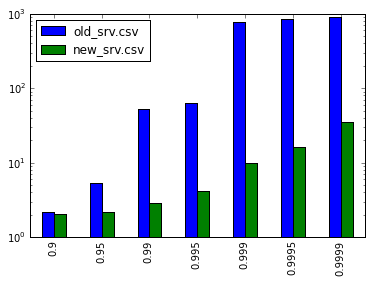

In [33]:
# note the log scale on the y axis
DATAFRAME.quantile([0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999]).plot(kind='bar', logy=True)

# Server Pauses
Another issue was the server periodically blocking for housekeeping tasks.  This led to extreme latency spikes at regular intervals.

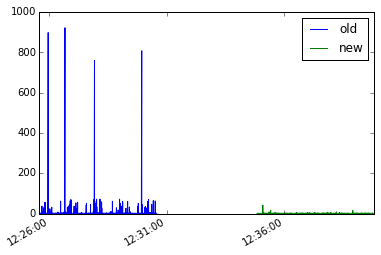

In [27]:
OLD.plot(legend=True, label="old")
NEW.plot(legend=True, label="new")

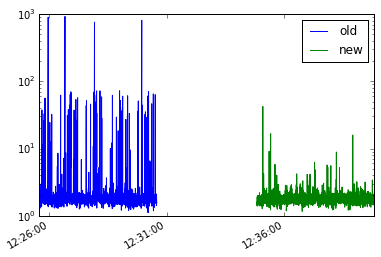

In [43]:
# Again, note the log scale on the y axis.
# Even with log scale, the new server was clearly made much less variable.
OLD.plot(legend=True, label="old", logy=True)
NEW.plot(legend=True, label="new", logy=True)

The difference between the old and the new is effectively night and day. So much so that it renders classical comparison tools like the QQ plot 

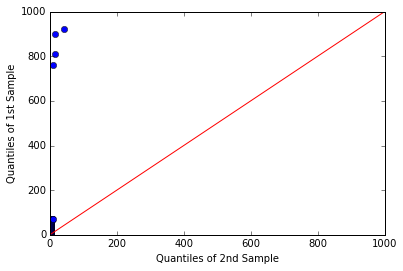

In [35]:
from statsmodels.graphics.gofplots import qqplot_2samples
import numpy

def qq_plot(x_data, y_data):
    x_pts, y_pts = x_data.values, y_data.values
    size = min(len(x_pts), len(y_pts))
    x_pts, y_pts = numpy.array(x_pts[:size], dtype='f'), numpy.array(y_pts[:size], dtype='f')
    qqplot_2samples(x_pts, y_pts, line='45')

qq_plot(OLD, NEW)